In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pip install --upgrade streamlit scikit-learn xgboost pandas matplotlib seaborn joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip list | grep -E "scikit-learn|xgboost|joblib|pandas|streamlit|dill|matpotlib"

Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
df = pd.read_excel(r"F:\primrose\data\AR - performance review - input.xlsx")

In [21]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason
2,1,99213,Medicare,Dr. Smith,0,100,16 - Missing information
3,2,99214,Aetna,Dr. Johnson,80,20,NaN
4,3,99215,Cigna,Dr. Lee,0,150,45 - Charge exceeds fee schedule


In [22]:
print(df.tail())

   Unnamed: 0 Unnamed: 1        Unnamed: 2   Unnamed: 3 Unnamed: 4 Unnamed: 5  \
23         22      99214             Aetna  Dr. Johnson         80         20   
24         23      99215             Cigna      Dr. Lee          0        150   
25         24      93000  UnitedHealthcare    Dr. Patel         50          0   
26         25      99212        Blue Cross      Dr. Kim          0         75   
27         26        NaN               NaN          NaN        NaN        NaN   

                          Unnamed: 6  
23                               NaN  
24  45 - Charge exceeds fee schedule  
25                               NaN  
26          96 - Non-covered service  
27                               NaN  


In [25]:
df_raw = pd.read_excel(r"F:\primrose\data\AR - performance review - input.xlsx", header=None)


header_row = df_raw.index[df_raw.iloc[:,1] == "CPT Code"][0]

df = pd.read_excel(r"F:\primrose\data\AR - performance review - input.xlsx", header=header_row)

print(df.head())

   #  CPT Code Insurance Company Physician Name  Payment Amount  Balance  \
0  1   99213.0          Medicare      Dr. Smith             0.0    100.0   
1  2   99214.0             Aetna    Dr. Johnson            80.0     20.0   
2  3   99215.0             Cigna        Dr. Lee             0.0    150.0   
3  4   93000.0  UnitedHealthcare      Dr. Patel            50.0      0.0   
4  5   99212.0        Blue Cross        Dr. Kim             0.0     75.0   

                      Denial Reason  
0          16 - Missing information  
1                               NaN  
2  45 - Charge exceeds fee schedule  
3                               NaN  
4          96 - Non-covered service  


In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   #                  26 non-null     int64  
 1   CPT Code           25 non-null     float64
 2   Insurance Company  25 non-null     object 
 3   Physician Name     25 non-null     object 
 4   Payment Amount     25 non-null     float64
 5   Balance            25 non-null     float64
 6   Denial Reason      15 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.6+ KB
None


In [28]:
print(df.isnull().sum())

#                     0
CPT Code              1
Insurance Company     1
Physician Name        1
Payment Amount        1
Balance               1
Denial Reason        11
dtype: int64


In [29]:
df['CPT Code'] = df['CPT Code'].astype(str).str.replace('.0','', regex=False)

In [30]:
df['CPT Code'] = df['CPT Code'].astype(str)

In [32]:
df["Payment Amount"] = df["Payment Amount"].replace(r'[\$,]', '', regex=True).astype(float)
df["Balance"] = df["Balance"].replace(r'[\$,]', '', regex=True).astype(float)

In [35]:
df.tail(2)   # check last 3 rows

,#,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason
24,25,99212,Blue Cross,Dr. Kim,0.0,75.0,96 - Non-covered service
25,26,nan,NaN,NaN,NaN,NaN,NaN


In [37]:
df = df[~((df["Insurance Company"] == "Unknown") & (df["Physician Name"] == "Unknown"))].reset_index(drop=True)

In [ ]:
df.tail(2)   

,#,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason
24,25,99212,Blue Cross,Dr. Kim,0.0,75.0,96 - Non-covered service
25,26,nan,NaN,NaN,NaN,NaN,NaN


In [ ]:

threshold = len(df.columns) * 0.8
df = df.dropna(thresh=threshold)


In [44]:
df.tail()

,#,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason
20,21,99213,Medicare,Dr. Smith,0.0,100.0,16 - Missing information
21,22,99214,Aetna,Dr. Johnson,80.0,20.0,NaN
22,23,99215,Cigna,Dr. Lee,0.0,150.0,45 - Charge exceeds fee schedule
23,24,93000,UnitedHealthcare,Dr. Patel,50.0,0.0,NaN
24,25,99212,Blue Cross,Dr. Kim,0.0,75.0,96 - Non-covered service


In [45]:
df.dropna()
df = df.drop_duplicates()
print(df.duplicated().sum())

df = df.reset_index(drop=True)

0


In [46]:
def split_denial_reason(x):
    if pd.isna(x):
        return pd.Series([None, None])
    parts = str(x).split('-', 1)  # split only at the first '-'
    if len(parts) == 2:
        return pd.Series([parts[0].strip(), parts[1].strip()])
    else:
        return pd.Series([parts[0].strip(), None])

df[['Denial Code', 'Denial Description']] = df['Denial Reason'].apply(split_denial_reason)

In [47]:
print("Dataset Shape:", df.shape)

Dataset Shape: (25, 9)


In [48]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
                #  Payment Amount     Balance
count  25.000000        25.00000   25.000000
mean   13.000000        26.00000   69.000000
std     7.359801        33.91165   55.377492
min     1.000000         0.00000    0.000000
25%     7.000000         0.00000   20.000000
50%    13.000000         0.00000   75.000000
75%    19.000000        50.00000  100.000000
max    25.000000        80.00000  150.000000


In [49]:
print("\nCleaned dataset:\n", df.head())


Cleaned dataset:
    # CPT Code Insurance Company Physician Name  Payment Amount  Balance  \
0  1    99213          Medicare      Dr. Smith             0.0    100.0   
1  2    99214             Aetna    Dr. Johnson            80.0     20.0   
2  3    99215             Cigna        Dr. Lee             0.0    150.0   
3  4    93000  UnitedHealthcare      Dr. Patel            50.0      0.0   
4  5    99212        Blue Cross        Dr. Kim             0.0     75.0   

                      Denial Reason Denial Code           Denial Description  
0          16 - Missing information          16          Missing information  
1                               NaN        None                         None  
2  45 - Charge exceeds fee schedule          45  Charge exceeds fee schedule  
3                               NaN        None                         None  
4          96 - Non-covered service          96          Non-covered service  


In [50]:
print("\nData types after cleaning:\n", df.dtypes)


Data types after cleaning:
 #                       int64
CPT Code               object
Insurance Company      object
Physician Name         object
Payment Amount        float64
Balance               float64
Denial Reason          object
Denial Code            object
Denial Description     object
dtype: object


In [51]:
df.tail()

,#,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason,Denial Code,Denial Description
20,21,99213,Medicare,Dr. Smith,0.0,100.0,16 - Missing information,16,Missing information
21,22,99214,Aetna,Dr. Johnson,80.0,20.0,NaN,None,None
22,23,99215,Cigna,Dr. Lee,0.0,150.0,45 - Charge exceeds fee schedule,45,Charge exceeds fee schedule
23,24,93000,UnitedHealthcare,Dr. Patel,50.0,0.0,NaN,None,None
24,25,99212,Blue Cross,Dr. Kim,0.0,75.0,96 - Non-covered service,96,Non-covered service


In [52]:
df = df.drop(columns=['#'], errors='ignore')
key = ["CPT Code","Insurance Company","Physician Name","Payment Amount","Balance","Denial Reason"]
df[key] = df[key].replace(['', ' ', 'nan', 'NaN', 'None'], pd.NA)
df = df[df[key].notna().any(axis=1)].reset_index(drop=True)

In [53]:
df["Is_Denied"] = df.apply(
    lambda x: True if pd.notna(x["Denial Reason"]) or (x["Payment Amount"] <= 0 and x["Balance"] > 0)
    else False, axis=1
)


In [54]:
def split_denial_reason(x):
    if pd.isna(x):
        return pd.Series([None, None])
    parts = str(x).split("-", 1)
    if len(parts) == 2:
        return pd.Series([parts[0].strip(), parts[1].strip()])
    return pd.Series([parts[0].strip(), None])

df[["Denial Code", "Denial Description"]] = df["Denial Reason"].apply(split_denial_reason)

In [55]:
# Top denied CPTs
cpt_summary = df.groupby("CPT Code").agg(
    total_claims=("CPT Code", "size"),
    denied_claims=("Is_Denied", "sum"),
    denial_rate=("Is_Denied", "mean"),
    total_balance=("Balance", "sum")
).reset_index().sort_values("denied_claims", ascending=False)

print("\nTop Denied CPTs:\n", cpt_summary.head())



Top Denied CPTs:
   CPT Code  total_claims  denied_claims  denial_rate  total_balance
1    99212             5              5          1.0          375.0
4    99215             5              5          1.0          750.0
2    99213             5              5          1.0          500.0
0    93000             5              0          0.0            0.0
3    99214             5              0          0.0          100.0


In [57]:
# Top denial reasons
denial_summary = df["Denial Description"].value_counts()
print("\nMost Common Denial Reasons:\n", denial_summary)



Most Common Denial Reasons:
 Denial Description
Missing information            5
Charge exceeds fee schedule    5
Non-covered service            5
Name: count, dtype: int64


In [58]:
# Denials by Payer
payer_summary = df.groupby("Insurance Company")["Is_Denied"].mean().sort_values(ascending=False)
print("\nDenial Rate by Insurance:\n", payer_summary)



Denial Rate by Insurance:
 Insurance Company
Blue Cross          1.0
Medicare            1.0
Cigna               1.0
Aetna               0.0
UnitedHealthcare    0.0
Name: Is_Denied, dtype: float64


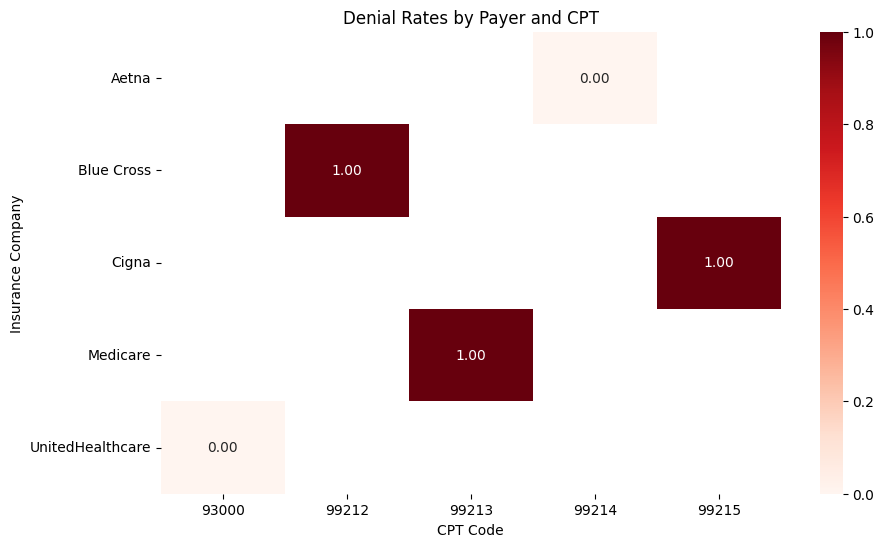

In [59]:
import seaborn as sns
pivot = df.pivot_table(index="Insurance Company", columns="CPT Code", values="Is_Denied", aggfunc="mean")
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title("Denial Rates by Payer and CPT")
plt.show()


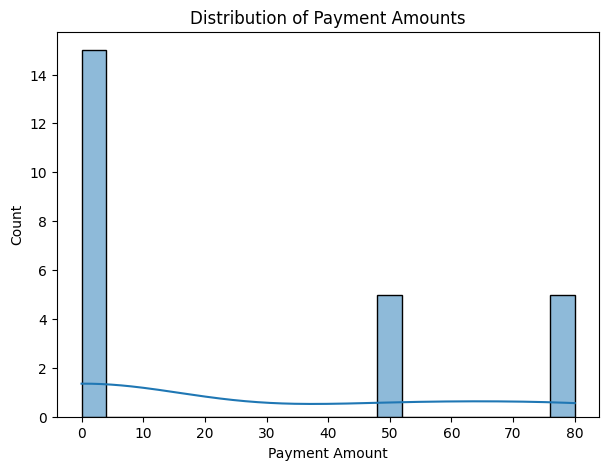

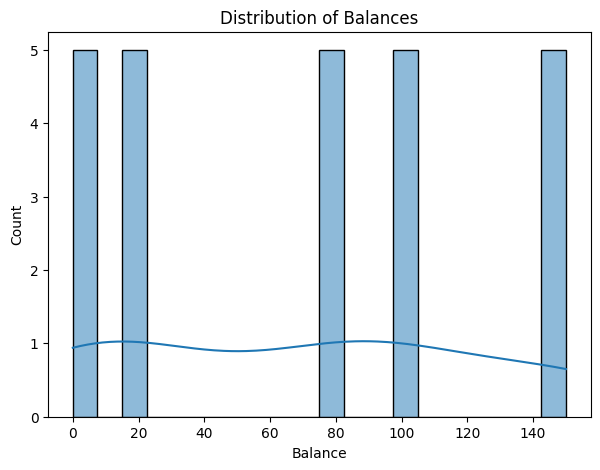

In [60]:
# Histogram for Payment Amount
plt.figure(figsize=(7,5))
sns.histplot(df['Payment Amount'], kde=True, bins=20)
plt.title("Distribution of Payment Amounts")
plt.show()

# Histogram for Balance
plt.figure(figsize=(7,5))
sns.histplot(df['Balance'], kde=True, bins=20)
plt.title("Distribution of Balances")
plt.show()

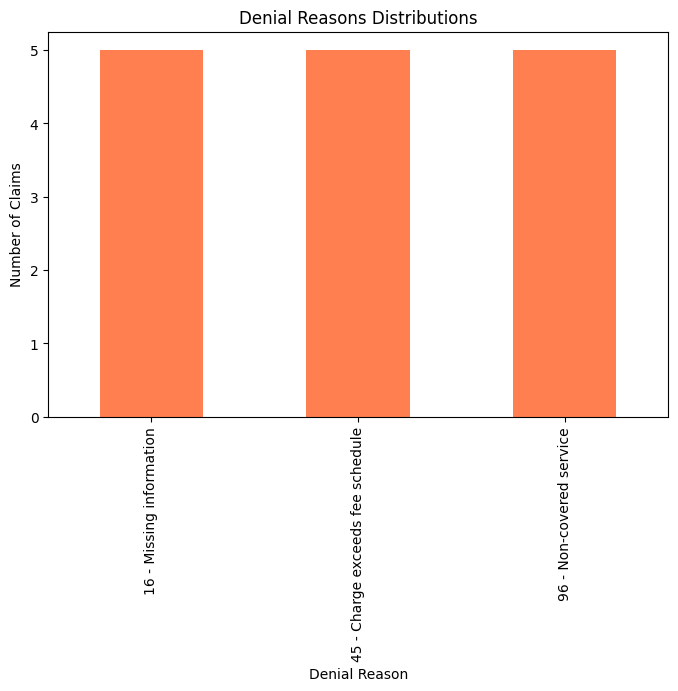

In [64]:
df["Denial Reason"].value_counts().plot(kind="bar", figsize=(8,5), color="coral")
plt.title("Denial Reasons Distributions")
plt.ylabel("Number of Claims")
plt.show()

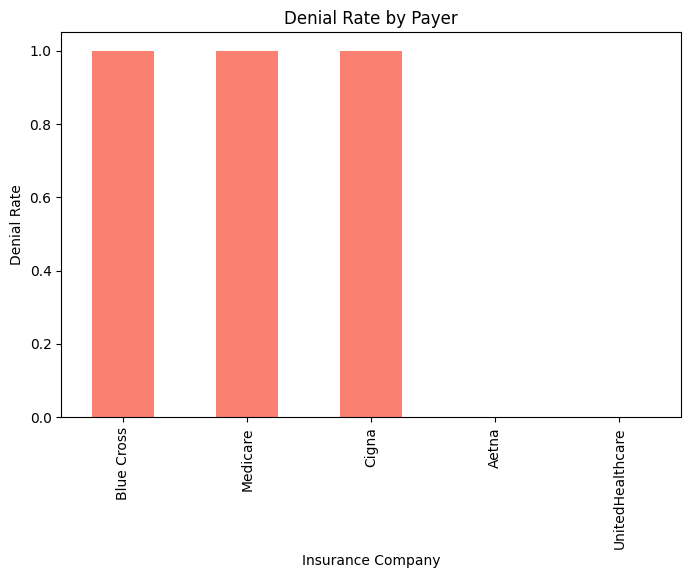

In [65]:
denial_rate_by_payer = df.groupby("Insurance Company")["Is_Denied"].mean().sort_values(ascending=False)
denial_rate_by_payer.plot(kind="bar", figsize=(8,5), color="salmon")
plt.title("Denial Rate by Payer")
plt.ylabel("Denial Rate")
plt.show()


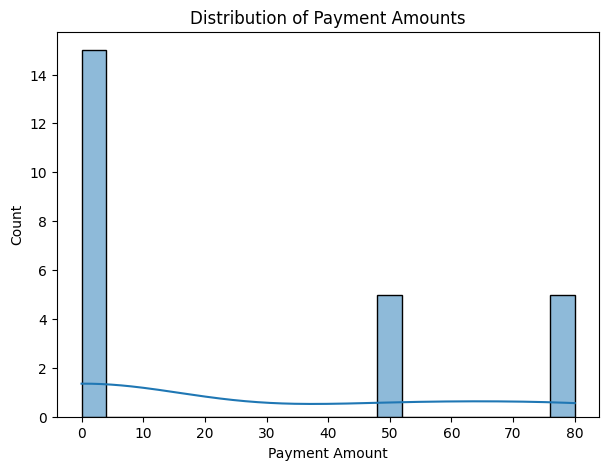

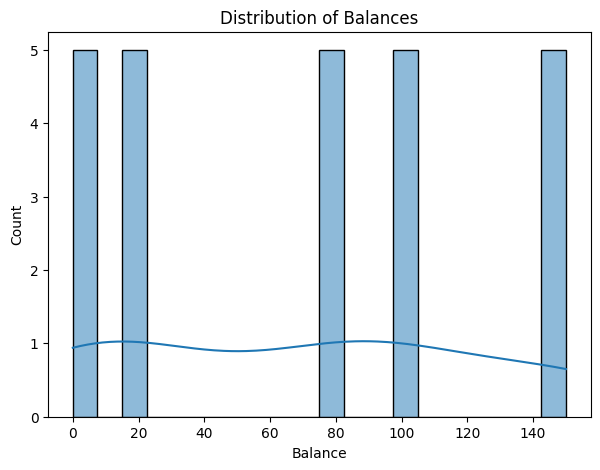

In [66]:
# Histogram for Payment Amount
plt.figure(figsize=(7,5))
sns.histplot(df['Payment Amount'], kde=True, bins=20)
plt.title("Distribution of Payment Amounts")
plt.show()

# Histogram for Balance
plt.figure(figsize=(7,5))
sns.histplot(df['Balance'], kde=True, bins=20)
plt.title("Distribution of Balances")
plt.show()



Average Payment per Insurance Company:
 Insurance Company
Aetna               80.0
UnitedHealthcare    50.0
Blue Cross           0.0
Cigna                0.0
Medicare             0.0
Name: Payment Amount, dtype: float64


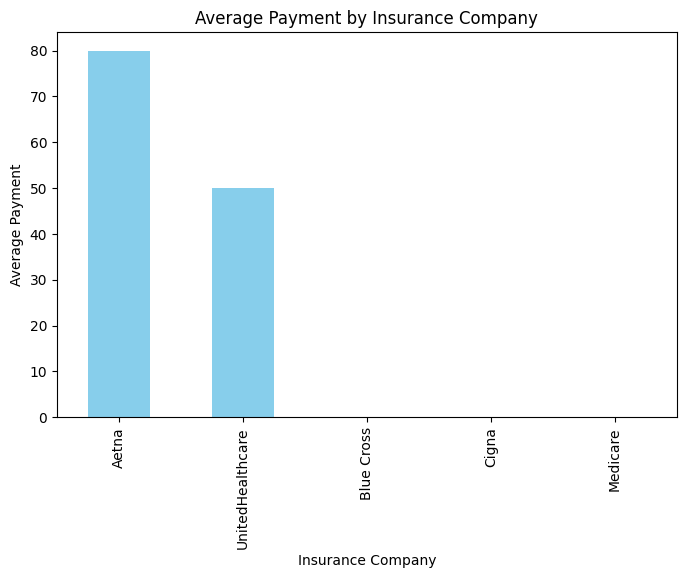

In [67]:
avg_payment = df.groupby("Insurance Company")["Payment Amount"].mean().sort_values(ascending=False)
print("\nAverage Payment per Insurance Company:\n", avg_payment)

# Visualization
plt.figure(figsize=(8,5))
avg_payment.plot(kind="bar", color="skyblue")
plt.title("Average Payment by Insurance Company")
plt.ylabel("Average Payment")
plt.show()

In [68]:

denial_counts = df["Denial Reason"].value_counts()
print("\nDenial Reasons:\n", denial_counts)
print( " Total denial reason in dataset - " , df["Denial Reason"].count())


Denial Reasons:
 Denial Reason
16 - Missing information            5
45 - Charge exceeds fee schedule    5
96 - Non-covered service            5
Name: count, dtype: int64
 Total denial reason in dataset -  15


In [69]:
total_claims = len(df)
denied_claims = df["Is_Denied"].sum()
denial_rate = denied_claims / total_claims
print(f"\nTotal claims: {total_claims}, Denied claims: {denied_claims}, Denial rate: {denial_rate:.2%}")


Total claims: 25, Denied claims: 15, Denial rate: 60.00%


In [70]:
for col in ['CPT Code', 'Insurance Company', 'Physician Name', 'Denial Reason']:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())


Unique values in CPT Code:
['99213' '99214' '99215' '93000' '99212']

Unique values in Insurance Company:
['Medicare' 'Aetna' 'Cigna' 'UnitedHealthcare' 'Blue Cross']

Unique values in Physician Name:
['Dr. Smith' 'Dr. Johnson' 'Dr. Lee' 'Dr. Patel' 'Dr. Kim']

Unique values in Denial Reason:
['16 - Missing information' nan '45 - Charge exceeds fee schedule'
 '96 - Non-covered service']


In [71]:
df.tail()

,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason,Denial Code,Denial Description,Is_Denied
20,99213,Medicare,Dr. Smith,0.0,100.0,16 - Missing information,16,Missing information,True
21,99214,Aetna,Dr. Johnson,80.0,20.0,NaN,None,None,False
22,99215,Cigna,Dr. Lee,0.0,150.0,45 - Charge exceeds fee schedule,45,Charge exceeds fee schedule,True
23,93000,UnitedHealthcare,Dr. Patel,50.0,0.0,NaN,None,None,False
24,99212,Blue Cross,Dr. Kim,0.0,75.0,96 - Non-covered service,96,Non-covered service,True


In [72]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 CPT Code               0
Insurance Company      0
Physician Name         0
Payment Amount         0
Balance                0
Denial Reason         10
Denial Code           10
Denial Description    10
Is_Denied              0
dtype: int64


In [73]:
df['Denial Reason'].unique()

array(['16 - Missing information', nan,
       '45 - Charge exceeds fee schedule', '96 - Non-covered service'],
      dtype=object)

In [74]:
avg_payment = df.groupby("Insurance Company")["Payment Amount"].mean().sort_values(ascending=False)
print(avg_payment)

Insurance Company
Aetna               80.0
UnitedHealthcare    50.0
Blue Cross           0.0
Cigna                0.0
Medicare             0.0
Name: Payment Amount, dtype: float64


In [75]:
denial_counts = df["Denial Reason"].value_counts()
print(denial_counts)

Denial Reason
16 - Missing information            5
45 - Charge exceeds fee schedule    5
96 - Non-covered service            5
Name: count, dtype: int64


In [76]:
for col in ['CPT Code', 'Insurance Company', 'Physician Name', 'Denial Reason']:
    print(df[col].unique())

['99213' '99214' '99215' '93000' '99212']
['Medicare' 'Aetna' 'Cigna' 'UnitedHealthcare' 'Blue Cross']
['Dr. Smith' 'Dr. Johnson' 'Dr. Lee' 'Dr. Patel' 'Dr. Kim']
['16 - Missing information' nan '45 - Charge exceeds fee schedule'
 '96 - Non-covered service']


In [77]:
print(df.isnull().sum())


CPT Code               0
Insurance Company      0
Physician Name         0
Payment Amount         0
Balance                0
Denial Reason         10
Denial Code           10
Denial Description    10
Is_Denied              0
dtype: int64


In [78]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define categorical and numeric columns
categorical_cols = ["CPT Code", "Insurance Company", "Physician Name"]
numeric_cols = ["Payment Amount", "Balance"]

# Preprocess pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocess pipeline for numeric data
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols)
    ]
)

In [79]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Features and target
X = df[["CPT Code", "Insurance Company", "Physician Name", "Payment Amount", "Balance"]]
# Ensure target has no NaN values
df["Denial Reason"] = df["Denial Reason"].fillna("No Denial").astype(str)

# Then encode
le_target = LabelEncoder()
y = le_target.fit_transform(df["Denial Reason"])

# Define categorical and numeric columns
categorical_cols = ["CPT Code", "Insurance Company", "Physician Name"]
numeric_cols = ["Payment Amount", "Balance"]


# Final model pipeline
logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000,random_state=42, class_weight="balanced"))
])


In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Fit the pipeline (preprocessing + model) to training data
logreg_model.fit(X_train, y_train)

# Predict on test data
y_pred = logreg_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
                                   precision    recall  f1-score   support

        16 - Missing information       1.00      1.00      1.00         1
45 - Charge exceeds fee schedule       1.00      1.00      1.00         2
        96 - Non-covered service       1.00      1.00      1.00         2
                       No Denial       1.00      1.00      1.00         3

                        accuracy                           1.00         8
                       macro avg       1.00      1.00      1.00         8
                    weighted avg       1.00      1.00      1.00         8


Confusion Matrix:
 [[1 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 3]]


In [81]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average CV accuracy:", scores.mean())


Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV accuracy: 1.0


In [82]:
!pip install xgboost==3.0.4

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [83]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Random Forest pipeline
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))

])

# XGBoost pipeline
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb.XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Now train and evaluate as usual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 1.0
                                  precision    recall  f1-score   support

        16 - Missing information       1.00      1.00      1.00         1
45 - Charge exceeds fee schedule       1.00      1.00      1.00         2
        96 - Non-covered service       1.00      1.00      1.00         2
                       No Denial       1.00      1.00      1.00         3

                        accuracy                           1.00         8
                       macro avg       1.00      1.00      1.00         8
                    weighted avg       1.00      1.00      1.00         8

[[1 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 3]]


In [84]:

# Train XGBoost
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le_target.classes_))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 1.0
                                  precision    recall  f1-score   support

        16 - Missing information       1.00      1.00      1.00         1
45 - Charge exceeds fee schedule       1.00      1.00      1.00         2
        96 - Non-covered service       1.00      1.00      1.00         2
                       No Denial       1.00      1.00      1.00         3

                        accuracy                           1.00         8
                       macro avg       1.00      1.00      1.00         8
                    weighted avg       1.00      1.00      1.00         8

[[1 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 3]]


In [85]:
from sklearn.model_selection import cross_val_score


cv_scores_logreg = cross_val_score(logreg_model, X, y, cv=5)
print("Logistic Regression cross-validation scores:", cv_scores_logreg)
print("Average Logistic Regression CV accuracy:", cv_scores_logreg.mean())



cv_scores = cross_val_score(rf_model, X, y, cv=5)
print("Random Forest cross-validation scores:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())




# Cross-validation for XGBoost
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5)
print("XGBoost cross-validation scores:", cv_scores_xgb)
print("Average XGBoost CV accuracy:", cv_scores_xgb.mean())


Logistic Regression cross-validation scores: [1. 1. 1. 1. 1.]
Average Logistic Regression CV accuracy: 1.0
Random Forest cross-validation scores: [1. 1. 1. 1. 1.]
Average CV accuracy: 1.0
XGBoost cross-validation scores: [1. 1. 1. 1. 1.]
Average XGBoost CV accuracy: 1.0


In [86]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Use only categorical features (remove Payment Amount & Balance)
categorical_only = ["CPT Code", "Insurance Company", "Physician Name"]

# Preprocessor for categorical data
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_categorical = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_only)]
)

# Logistic Regression pipeline
logreg_model_cat = Pipeline(steps=[
    ("preprocessor", preprocessor_categorical),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Random Forest pipeline
rf_model_cat = Pipeline(steps=[
    ("preprocessor", preprocessor_categorical),
    ("classifier", RandomForestClassifier(random_state=42))
])

# XGBoost pipeline
xgb_model_cat = Pipeline(steps=[
    ("preprocessor", preprocessor_categorical),
    ("classifier", xgb.XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# --- Cross-validation for each model ---
cv_scores_logreg_cat = cross_val_score(logreg_model_cat, X, y, cv=5, scoring="accuracy")
print("Logistic Regression (categorical only) CV scores:", cv_scores_logreg_cat)
print("Average accuracy:", cv_scores_logreg_cat.mean())

cv_scores_rf_cat = cross_val_score(rf_model_cat, X, y, cv=5, scoring="accuracy")
print("\nRandom Forest (categorical only) CV scores:", cv_scores_rf_cat)
print("Average accuracy:", cv_scores_rf_cat.mean())

cv_scores_xgb_cat = cross_val_score(xgb_model_cat, X, y, cv=5, scoring="accuracy")
print("\nXGBoost (categorical only) CV scores:", cv_scores_xgb_cat)
print("Average accuracy:", cv_scores_xgb_cat.mean())


Logistic Regression (categorical only) CV scores: [1. 1. 1. 1. 1.]
Average accuracy: 1.0

Random Forest (categorical only) CV scores: [1. 1. 1. 1. 1.]
Average accuracy: 1.0

XGBoost (categorical only) CV scores: [1. 1. 1. 1. 1.]
Average accuracy: 1.0


In [87]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
logreg_model.fit(X_train, y_train)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])
rf_model.fit(X_train, y_train)

# XGBoost
from xgboost import XGBClassifier
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"))
])
xgb_model.fit(X_train, y_train)


c:\Users\Ramana\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


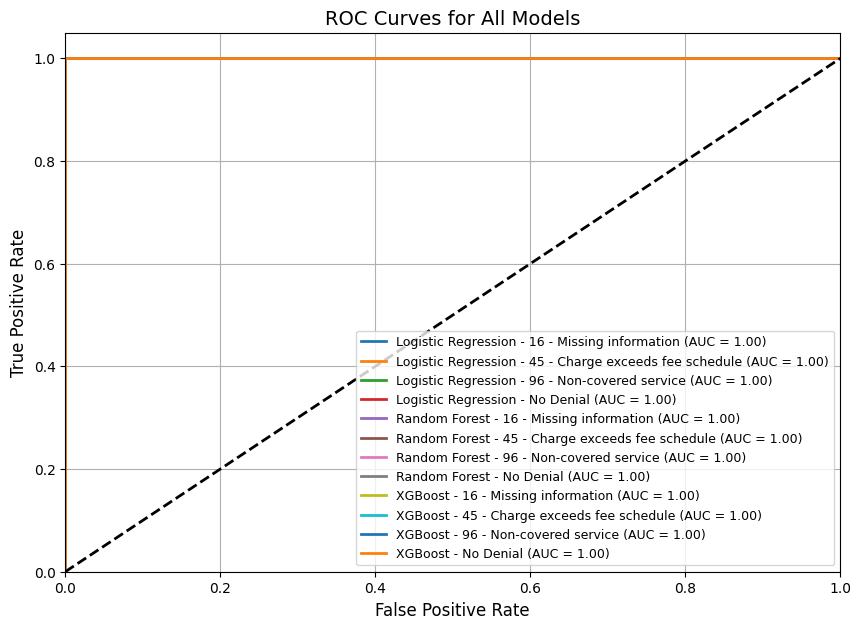

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=list(range(len(le_target.classes_))))
n_classes = y_test_bin.shape[1]

# Initialize figure
plt.figure(figsize=(10, 7))

models = {
    "Logistic Regression": logreg_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}


# Loop through models
for name, model in models.items():
    # Predict probabilities
    y_score = model.predict_proba(X_test)
    
    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,
                 label=f"{name} - {le_target.classes_[i]} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], "k--", lw=2)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves for All Models", fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()


In [89]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")


--- Logistic Regression ---
Accuracy: 1.0
Confusion Matrix:
 [[1 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



--- Random Forest ---
Accuracy: 1.0
Confusion Matrix:
 [[1 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                         

In [90]:
import warnings
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore", category=UserWarning)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"{name} CV Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")


Logistic Regression CV Accuracy: 1.000 (+/- 0.000)
Random Forest CV Accuracy: 1.000 (+/- 0.000)
XGBoost CV Accuracy: 1.000 (+/- 0.000)


In [91]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

# Define categorical columns
categorical_cols = ['CPT Code', 'Insurance Company', 'Physician Name']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# XGBoost model
xgb_clf = XGBClassifier( eval_metric='mlogloss')

# Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_clf)])

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.1],
    'classifier__reg_lambda': [1, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.8}
Best CV Accuracy: 1.0


In [92]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Categorical columns
categorical_cols = ['CPT Code', 'Insurance Company', 'Physician Name']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# Build pipeline with preprocessing + XGBoost
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        colsample_bytree=0.8,
        gamma=0,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=100,
        reg_lambda=1,
        subsample=0.8,
        random_state=42,
        eval_metric="logloss"
    ))
])

# Train
best_model.fit(X_train, y_train)

# Predict
y_pred = best_model.predict(X_test)


In [93]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Confusion Matrix:
 [[1 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 3]]


C:\Users\Ramana\AppData\Local\Temp\ipykernel_24044\3563767798.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Denial Reason", data=df, palette="Set2")


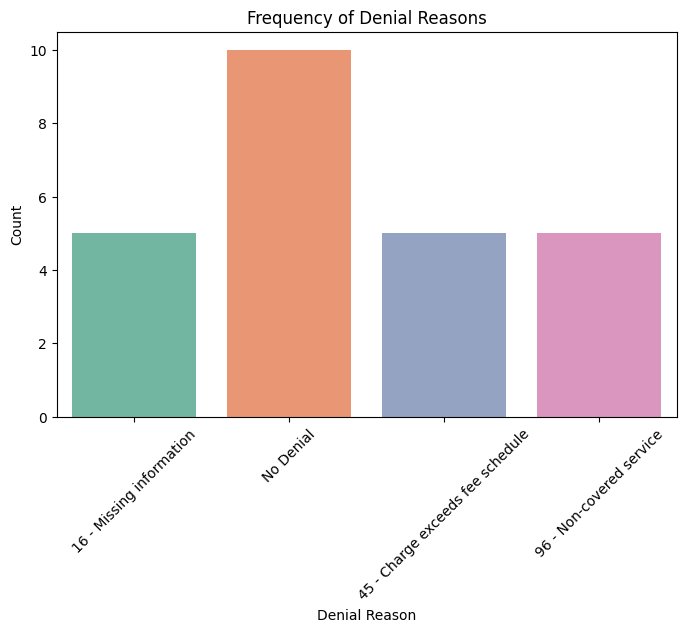

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x="Denial Reason", data=df, palette="Set2")
plt.title("Frequency of Denial Reasons")
plt.xlabel("Denial Reason")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


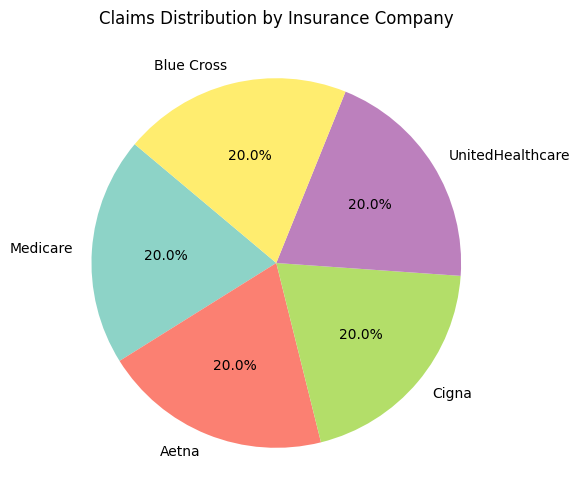

In [95]:
plt.figure(figsize=(6,6))
df["Insurance Company"].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap="Set3")
plt.title("Claims Distribution by Insurance Company")
plt.ylabel("")
plt.show()


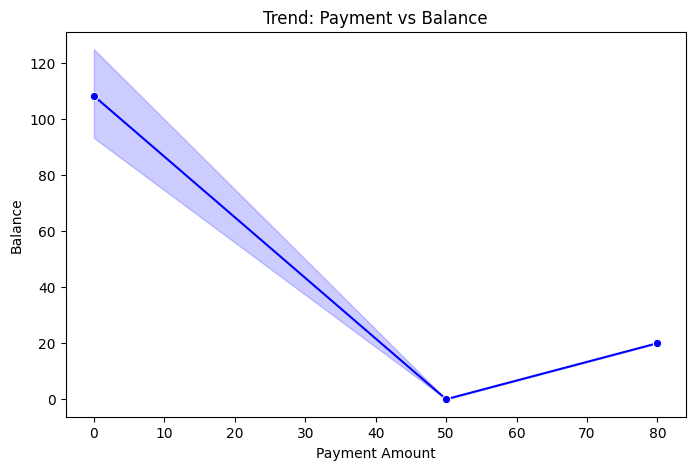

In [96]:
plt.figure(figsize=(8,5))
sns.lineplot(x="Payment Amount", y="Balance", data=df, marker="o", color="blue")
plt.title("Trend: Payment vs Balance")
plt.xlabel("Payment Amount")
plt.ylabel("Balance")
plt.show()


In [97]:
import joblib

# 📂 Make sure "models" folder exists
import os
os.makedirs("models", exist_ok=True)

# Save LabelEncoder
joblib.dump(le_target, "models/label_encoder.joblib")

# Save all models
joblib.dump(logreg_model, "models/logreg_pipeline.joblib")
joblib.dump(rf_model, "models/rf_pipeline.joblib")

# Save best tuned XGBoost model (from GridSearch)
best_model = grid_search.best_estimator_
joblib.dump(best_model, "models/xgb_pipeline.joblib")

print("✅ Models and encoder saved successfully in 'models/' folder")


✅ Models and encoder saved successfully in 'models/' folder


In [98]:
# The error indicates that the parameter 'max_depth' is not being passed correctly to the XGBClassifier within the pipeline.
# To fix this, we need to prefix the parameter with 'classifier__' to specify that it belongs to the 'classifier' step in the pipeline.

# Corrected code:
grid_search = GridSearchCV(
    estimator=pipeline,   
    param_grid={
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__gamma': [0, 0.1],
        'classifier__reg_lambda': [1, 5, 10]
    },
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.8}
Best CV Accuracy: 1.0


In [99]:
import joblib

# After grid_search.fit(X, y)
bundle = {
    "pipeline": grid_search.best_estimator_,
    "label_encoder": le_target,   # if you used one
    "cv_results": grid_search.cv_results_,
    "best_params": grid_search.best_params_,
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "roc_curve": roc_curve(y_test, grid_search.best_estimator_.predict_proba(X_test)[:,1]) if len(np.unique(y_test)) == 2 else None
}

joblib.dump(bundle, "models/xgb_bundle.joblib")


['models/xgb_bundle.joblib']

In [100]:
import joblib
from sklearn.metrics import classification_report, roc_curve

# After GridSearchCV is done
best_model = grid_search.best_estimator_

# (optional) hold-out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Bundle everything
bundle = {
    "pipeline": best_model,
    "label_encoder": le_target if "le_target" in globals() else None,  # only if you used one
    "cv_results": grid_search.cv_results_,
    "best_params": grid_search.best_params_,
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "roc_curve": roc_curve(y_test, best_model.predict_proba(X_test)[:,1]) if len(np.unique(y_test)) == 2 else None
}

joblib.dump(bundle, "models/xgb_bundle.joblib")


['models/xgb_bundle.joblib']

In [101]:
df.tail()

,CPT Code,Insurance Company,Physician Name,Payment Amount,Balance,Denial Reason,Denial Code,Denial Description,Is_Denied
20,99213,Medicare,Dr. Smith,0.0,100.0,16 - Missing information,16,Missing information,True
21,99214,Aetna,Dr. Johnson,80.0,20.0,No Denial,None,None,False
22,99215,Cigna,Dr. Lee,0.0,150.0,45 - Charge exceeds fee schedule,45,Charge exceeds fee schedule,True
23,93000,UnitedHealthcare,Dr. Patel,50.0,0.0,No Denial,None,None,False
24,99212,Blue Cross,Dr. Kim,0.0,75.0,96 - Non-covered service,96,Non-covered service,True


In [102]:
import sklearn
print(sklearn.__version__)

1.7.1


In [103]:
# Correcting the syntax to find the Python version
import sys
print("Python version:", sys.version)

Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]


In [104]:
import sklearn, xgboost, joblib
print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)



sklearn: 1.7.1
xgboost: 3.0.4
joblib: 1.5.2


In [107]:
%pip list | grep -E "scikit-learn|xgboost|joblib|pandas|streamlit|dill"


Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [110]:
%pip list | grep -E "scikit-learn|xgboost|joblib|pandas|streamlit|dill|matplotlib"

Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.



🔹 Top Denied CPT Codes:
 CPT Code
99213    5
99215    5
99212    5
Name: count, dtype: int64

🔹 Top Denying Insurers:
 Insurance Company
Medicare      5
Cigna         5
Blue Cross    5
Name: count, dtype: int64

🔹 Top Denial Reasons:
 Denial Reason
No Denial                           10
16 - Missing information             5
45 - Charge exceeds fee schedule     5
96 - Non-covered service             5
Name: count, dtype: int64

🔹 CPTs with Lowest Payment Efficiency:
 CPT Code
99212    0.0
99213    0.0
99215    0.0
99214    0.8
93000    1.0
Name: Payment Efficiency, dtype: float64


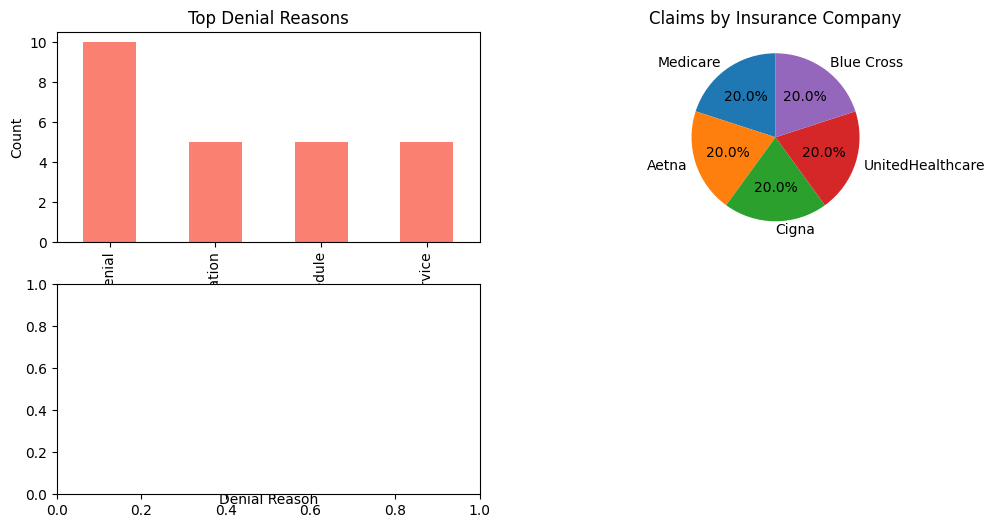

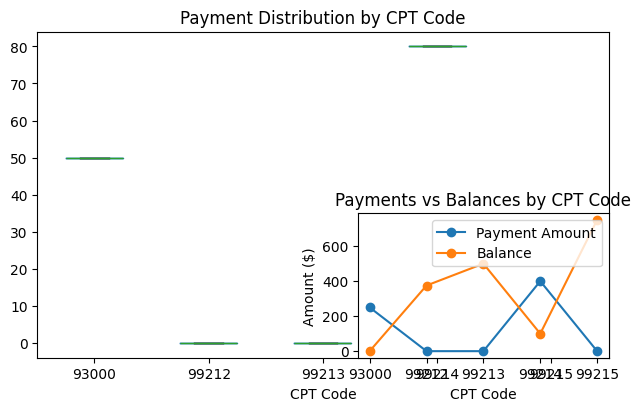

In [112]:
import pandas as pd
import matplotlib.pyplot as plt


def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace("$", "").replace(",", "").strip())
    return x

df["Payment Amount"] = df["Payment Amount"].apply(clean_currency)
df["Balance"] = df["Balance"].apply(clean_currency)

# ----------------------------
# Step 3: Calculate Metrics
# ----------------------------
df["Total Charge"] = df["Payment Amount"] + df["Balance"]
df["Payment Efficiency"] = df["Payment Amount"] / df["Total Charge"].replace(0, 1)

# ----------------------------
# Step 4: Insights
# ----------------------------
# Top denied CPTs (Payment = 0)
denied_cpts = df[df["Payment Amount"] == 0]["CPT Code"].value_counts().head(5)

# Top insurers causing denials
denied_insurers = df[df["Payment Amount"] == 0]["Insurance Company"].value_counts().head(5)

# Top denial reasons
denial_reasons = df["Denial Reason"].dropna().value_counts().head(5)

# Lowest payment efficiency CPT codes
inefficiencies = df.groupby("CPT Code")["Payment Efficiency"].mean().sort_values().head(5)

print("\n🔹 Top Denied CPT Codes:\n", denied_cpts)
print("\n🔹 Top Denying Insurers:\n", denied_insurers)
print("\n🔹 Top Denial Reasons:\n", denial_reasons)
print("\n🔹 CPTs with Lowest Payment Efficiency:\n", inefficiencies)

# ----------------------------
# Step 5: Visualizations
# ----------------------------
plt.figure(figsize=(12, 6))

# Bar chart: denial reasons
plt.subplot(2, 2, 1)
denial_reasons.plot(kind="bar", color="salmon")
plt.title("Top Denial Reasons")
plt.ylabel("Count")

# Pie chart: claim distribution by insurer
plt.subplot(2, 2, 2)
df["Insurance Company"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Claims by Insurance Company")
plt.ylabel("")

# Boxplot: payment distribution across CPT codes
plt.subplot(2, 2, 3)
df.boxplot(column="Payment Amount", by="CPT Code", grid=False)
plt.title("Payment Distribution by CPT Code")
plt.suptitle("")

# Trend line: Payments vs Balances by CPT
plt.subplot(2, 2, 4)
df.groupby("CPT Code")[["Payment Amount", "Balance"]].sum().plot(marker="o", ax=plt.gca())
plt.title("Payments vs Balances by CPT Code")
plt.xlabel("CPT Code")
plt.ylabel("Amount ($)")

plt.tight_layout()
plt.show()
